1. Using scipy to import channel data into python

In [196]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [197]:
mat16A = scipy.io.loadmat('./data/2017.10.18_16.58.07_1.A.mat')
mat16B = scipy.io.loadmat('./data/2017.10.18_16.58.07_1.B.mat')
mat17A = scipy.io.loadmat('./data/2017.10.18_17.10.19_1.A.mat')
mat17B = scipy.io.loadmat('./data/2017.10.18_17.10.19_1.B.mat')

mat16A.items()

dict_items([('T1', array([[0.0000000e+00, 2.0000000e-07, 4.0000000e-07, ..., 3.3554426e+00,
        3.3554428e+00, 3.3554430e+00]])), ('Y1', array([[7988, 7994, 7952, ..., 7986, 7998, 7960]], dtype=uint16))])

2. Plots portion of the raw data

In [198]:
mat16A['T1'].shape

(1, 16777216)

In [199]:
x1 = mat16A['T1'][0,:]
y1 = mat16A['Y1'][0,:]

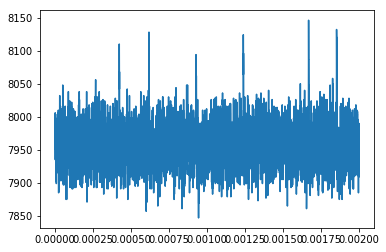

In [200]:
plt.plot(x1[:10000],y1[:10000])
plt.show()

3. The next step is to plot a histogram of the peak data to get an idea for the thresholds for certain number of photons

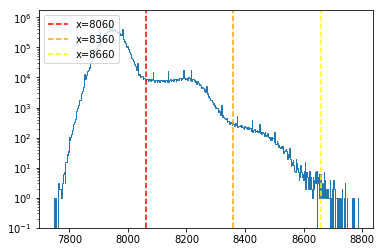

In [201]:
# Vertical lines drawn at 8060, 8360, 8660 corresponding to 1, 2, or 3 photons
# These thresholds are handpicked, and frequencies are still rather large at the threshold values, thresholds should ideally be at dips
plt.hist(y1,bins=500,log=True,histtype='step')
plt.axvline(x=8060,linestyle='dashed', color='red',label='x=8060')
plt.axvline(x=8360,linestyle='dashed', color='orange', label='x=8360')
plt.axvline(x=8660,linestyle='dashed', color='yellow', label='x=8660')
plt.legend()
plt.show()

4. Let's try some peak detection using derivatives done through convolution kernels

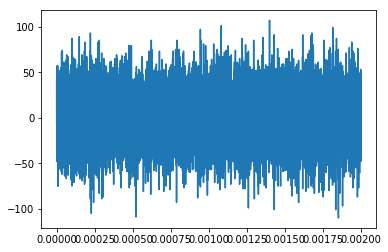

In [202]:
y2 = np.convolve(y1,[-1,1],mode='valid') #this is noisy need to find how many points wide a typical peak is
plt.plot(x1[:10000],y2[:10000])
plt.show()

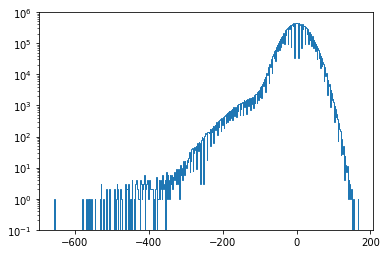

In [203]:
plt.hist(y2,bins=500,log=True,histtype='step')
plt.show()

This looks like a backwards histogram of the total peak heights. The "bumps" or stairsteps are occurring because of the different negative exponential falloffs for different photon numbers

# 5. Let's do some filtering to start counting peak heights (WIP)

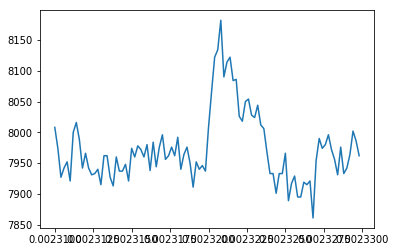

In [204]:
xs1p = x1[11550:11650]
ys1p = y1[11550:11650]
plt.plot(xs1p,ys1p)
plt.show()

# scipy.ndimage.filters.maximum_filter1d


# 6. Let's use Scipy's Peak Finder
## 6.1 Consider a Single Peak

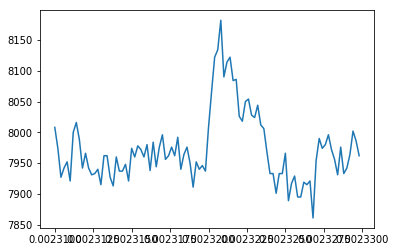

In [205]:
xs1p = x1[11550:11650]
ys1p = y1[11550:11650]
plt.plot(xs1p,ys1p)
plt.show()

The total peak is around 30 samples wide

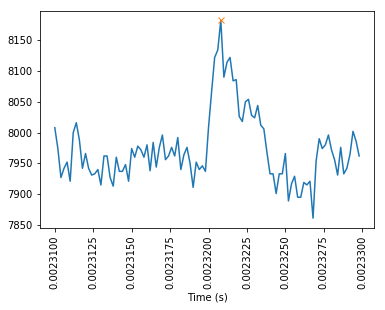

In [206]:
from scipy.signal import find_peaks
#change x to us from s
# xs1p=xs1p*(10**6)


#look for peaks above 1 photon threshold and with horizontal distance of peak width????
# 100 samples, time difference is 
peaks, _ = find_peaks(ys1p, height=8060,distance=10) #peaks are the x indices

# plot graph with detected peaks over it, convert to us
plt.plot(xs1p,ys1p)
plt.plot(xs1p[peaks], ys1p[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()

## 6.2 Let's try multiple peaks

In [207]:
xsmp = x1[:10000]
ysmp = y1[:10000]
#plt.plot(xsmp,ysmp)
#plt.show()

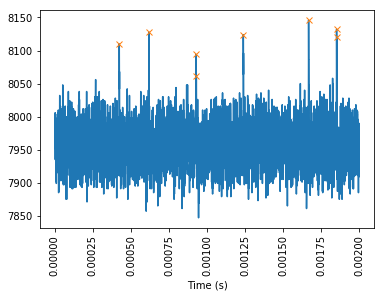

(8,)

In [208]:
peaks, _ = find_peaks(ysmp, height=8060,distance=10) #peaks are the x indices

# plot graph with detected peaks over it
plt.plot(xsmp,ysmp)
plt.plot(xsmp[peaks], ysmp[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()
peaks.shape

Let's investigate the 3rd peak

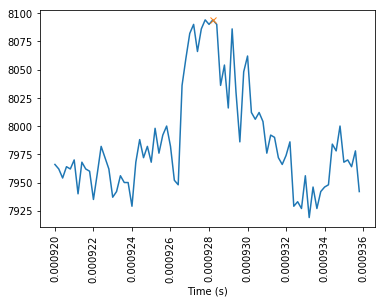

(1,)

In [209]:
xinv = xsmp[4600:4680]
yinv = ysmp[4600:4680]

peaks, _ = find_peaks(yinv, height=8060,distance=10) #peaks are the x indices

# plot graph with detected peaks over it
plt.plot(xinv,yinv)
plt.plot(xinv[peaks], yinv[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()
peaks.shape

This worked fine this time. However, the above is likely occurring because of a window offset, might want to increase the horizontal distance between peaks to around 15 

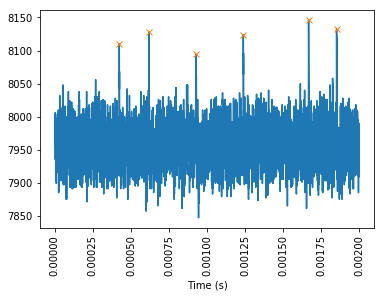

(6,)

In [210]:
peaks, _ = find_peaks(ysmp, height=8060,distance=15) #peaks are the x indices

# plot graph with detected peaks over it
plt.plot(xsmp,ysmp)
plt.plot(xsmp[peaks], ysmp[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()
peaks.shape

## 6.3 Let's run this on a big portion of dataset

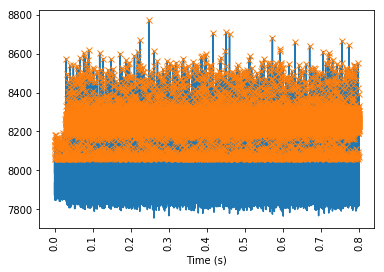

(17818,)

In [213]:
16777216

x1mass = x1[:4000000]
y1mass = y1[:4000000]

peaks, _ = find_peaks(y1mass, height=8060,distance=15) #peaks are the x indices

# plot graph with detected peaks over it
plt.plot(x1mass,y1mass)
plt.plot(x1mass[peaks], y1mass[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()
peaks.shape

Histogram the peak heights

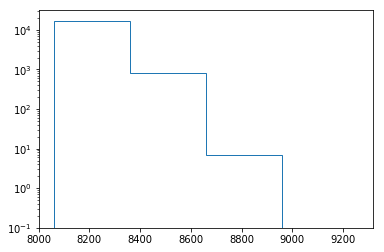

In [225]:
peak_heights = y1mass[peaks]

# bin according to the thresholds I projected before
plt.hist(peak_heights, bins=[8060,8360,8660,8960,9260], log=True,histtype='step')
plt.show()

Now Lets see how good these thresholds are, theoretically should see normal distributions around center of each peak area

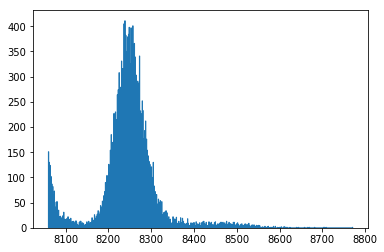

In [229]:
plt.hist(peak_heights, bins=1000, log=False,histtype='step')
plt.show()

Looks like the average for 1 photon is really around 8250. Why is there a peak around 8060??? Are these noise peaks?

# 7 Now let's try this on the different set of data

max peak height for this set of data is:  9016


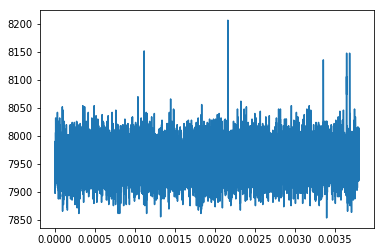

In [193]:
x2 = mat17A['T1'][0,:]
y2 = mat17A['Y1'][0,:]
print("max peak height for this set of data is: ", max(y2))

xsmp = x2[:19000]
ysmp = y2[:19000]

plt.plot(xsmp,ysmp)
plt.show()

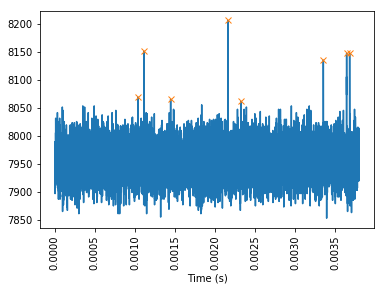

(8,)

In [194]:
peaks, _ = find_peaks(ysmp, height=8060,distance=15) #peaks are the x indices

# plot graph with detected peaks over it
plt.plot(xsmp,ysmp)
plt.plot(xsmp[peaks], ysmp[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()
peaks.shape

Threshold might need adjusting for this set of data

filter mean is: 8060.354308545589


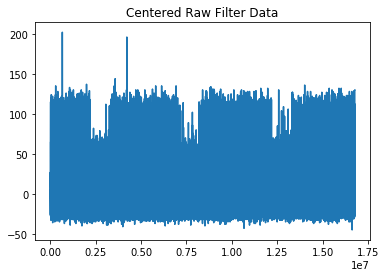

opo mean: 8069.392751932144


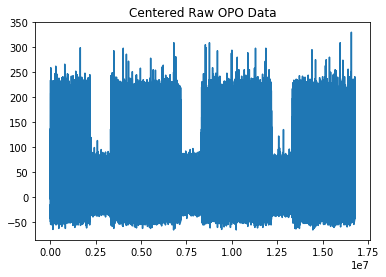

In [6]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.signal import find_peaks, correlate


# filename  
dataSet = "Nov 18th/2018.11.18_16.11.35_1"

matA = scipy.io.loadmat('./data/'+dataSet+'.A.mat')
matB = scipy.io.loadmat('./data/'+dataSet+'.B.mat')

xf = matB['T1'][0,:]
yf = matB['Y1'][0,:]

xo = matA['T1'][0,:]
yo = matA['Y1'][0,:]


#subtract out the zero level
yt_filter = yf.astype(float)
filter_mean = np.mean(yt_filter)
yt_filter -= filter_mean
print("filter mean is: " + str(filter_mean))

plt.figure()
plt.title("Centered Raw Filter Data")
plt.plot(yt_filter)
plt.show()

yt_opo = yo.astype(float)
opo_mean = np.mean(yt_opo)
yt_opo -= opo_mean
print("opo mean: " + str(opo_mean))

plt.figure()
plt.title("Centered Raw OPO Data")
plt.plot(yt_opo)
plt.show()


without shifting:  [37045798.36948416]
-30 37045798.36434539
-25 37045798.36434539
-20 37045798.36434539
-15 37045798.36434539
-10 37045798.36434539
-5 37045798.36434539
0 37045798.36434539
5 37045798.36434539
10 37045798.36434539
15 37045798.36434539
20 37045798.36434539
25 37045798.36434539
12


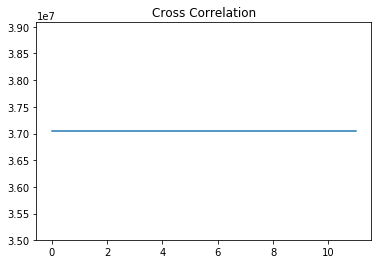

In [7]:
from scipy.ndimage.interpolation import shift

print("without shifting: ",scipy.signal.correlate(yt_filter,yt_opo, mode='valid'))

corr = []
for i in range(-30,30,5):
    filter_shifted = yt_filter
    shift(filter_shifted,i, cval=0)
    v = sum(filter_shifted*yt_opo)
    print(i,v)
    corr.append(v)

print(len(corr))
plt.title("Cross Correlation")
plt.plot(corr)
plt.show()

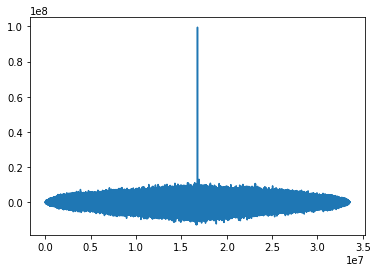

In [4]:
corr = scipy.signal.correlate(yt_filter,yt_opo, mode='full')
plt.plot(corr)
plt.show()
# LETS TRY LOG = TRUE?